# 5.12 稠密连接网络（DenseNet）

ResNet中的跨层连接设计引申出了数个后续工作。本节我们介绍其中的一个：稠密连接网络（DenseNet） [1]。 它与ResNet的主要区别如图5.10所示。

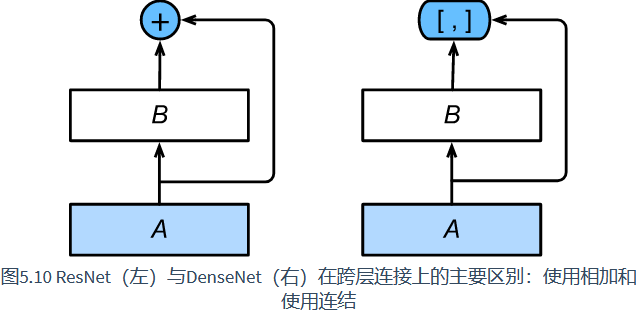

图5.10中将部分前后相邻的运算抽象为模块A和模块B。与ResNet的主要区别在于，DenseNet里模块BB的输出不是像ResNet那样和模块A的输出相加，而是在通道维上连结。这样模块A的输出可以直接传入模块B后面的层。在这个设计里，模块A直接跟模块B后面的所有层连接在了一起。这也是它被称为“稠密连接”的原因。

DenseNet的主要构建模块是稠密块（dense block）和过渡层（transition layer）。前者定义了输入和输出是如何连结的，后者则用来控制通道数，使之不过大。

## 5.12.1 稠密块

DenseNet使用了ResNet改良版的“批量归一化、激活和卷积”结构，我们首先在conv_block函数里实现这个结构。

In [3]:
import time
import torch
from torch import nn,optim
import torch.nn.functional as F

import sys
sys.path.append("..")
import d2lzh_pytorch as d2l
device=torch.device('cuda' if torch.cuda.is_available()else 'cpu')

def conv_block(in_channels,out_channels):
    blk=nn.Sequential(nn.BatchNorm2d(in_channels),
                     nn.ReLU(),
                     nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1)
        )
    return blk

稠密块由多个conv_block组成，每块使用相同的输出通道数。但在前向计算时，我们将每块的输入和输出在通道维上连结。

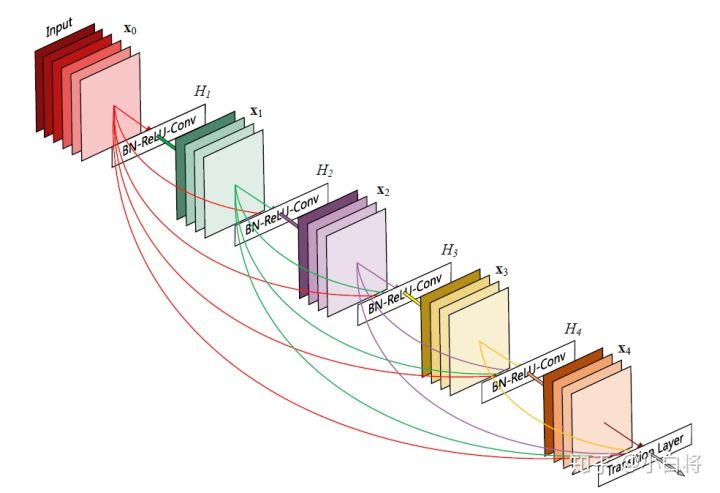

In [4]:
class DenseBlock(nn.Module):
    def __init__(self,num_convs,in_channels,out_channels):
        super(DenseBlock,self).__init__()
        net=[]
        for i in range(num_convs):
            in_c=in_channels+i*out_channels 
            #在每个denseblock将上一层的输出加到下一层的输入中
            net.append(conv_block(in_c,out_channels))
        self.net=nn.ModuleList(net)
        self.out_channels=in_channels+num_convs*out_channels#num_convs是conv_block中卷积层的数量
    
    def forward(self,X):
        for blk in self.net:
            Y=blk(X)
            X=torch.cat((X,Y),dim=1)#在通道维上将输入和输出连结
        return X
            

定义一个有2个输出通道数为10的卷积块。使用通道数为3的输入时，我们会得到通道数为3+2×10=23的输出。卷积块的通道数控制了输出通道数相对于输入通道数的增长，因此也被称为增长率（growth rate）。

In [5]:
blk=DenseBlock(2,3,10)
X=torch.rand(4,3,8,8)
Y=blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

## 5.12.2 过渡层

由于每个稠密块都会带来通道数的增加，使用过多则会带来过于复杂的模型。过渡层用来控制模型复杂度。它通过1×1卷积层来减小通道数，并使用步幅为2的平均池化层减半高和宽，从而进一步降低模型复杂度。

In [6]:
def  transition_block(in_channels,out_channels):
    blk=nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels,out_channels,kernel_size=1),
        nn.AvgPool2d(kernel_size=2,stride=2)
    )
    return blk

对上一个例子中稠密块的输出使用通道数为10的过渡层。此时输出的通道数减为10，高和宽均减半。

In [7]:
blk=transition_block(23,10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

## 5.12.3 DenseNet模型

DenseNet首先使用同ResNet一样的单卷积层和最大池化层。

In [8]:
net=nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)

类似于ResNet接下来使用的4个残差块，DenseNet使用的是4个稠密块。同ResNet一样，我们可以设置每个稠密块使用多少个卷积层。这里我们设成4，从而与上一节的ResNet-18保持一致。稠密块里的卷积层通道数（即增长率）设为32，所以每个稠密块将增加128个通道。

ResNet里通过步幅为2的残差块在每个模块之间减小高和宽。这里我们则使用过渡层来减半高和宽，并减半通道数。

In [9]:
num_channels,growth_rate=64,32 #num_channels为当前的通道数
num_convs_in_dense_blocks=[4,4,4,4]#稠密块的数量为4

for i,num_convs in enumerate(num_convs_in_dense_blocks):
    DB=DenseBlock(num_convs,num_channels,growth_rate)#num_convs是稠密块中卷积层的数量
    net.add_module("DenseBlock_%d"%i,DB)
    #上一个稠密块的输出通道数
    num_channels=DB.out_channels
    #在稠密块之间加入通道数减半的过渡层
    if i!=len(num_convs_in_dense_blocks)-1:
        net.add_module("transition_block_%d"%i,transition_block(num_channels,num_channels//2))
        num_channels=num_channels//2

同ResNet一样，最后接上全局池化层和全连接层来输出

In [12]:
net.add_module("BN",nn.BatchNorm2d(num_channels))
net.add_module("relu",nn.ReLU())
net.add_module("global_avg_pool",d2l.GlobalAvgPool2d())# GlobalAvgPool2d的输出: (Batch, num_channels, 1, 1)
net.add_module("fc",nn.Sequential(d2l.FlattenLayer(),nn.Linear(num_channels,10)))

In [13]:
X=torch.rand(1,1,96,96)
for name,layer in net.named_children():
    X=layer(X)
    print(name,'output shape:\t',X.shape)

0 output shape:	 torch.Size([1, 64, 48, 48])
1 output shape:	 torch.Size([1, 64, 48, 48])
2 output shape:	 torch.Size([1, 64, 48, 48])
3 output shape:	 torch.Size([1, 64, 24, 24])
DenseBlock_0 output shape:	 torch.Size([1, 192, 24, 24])
transition_block_0 output shape:	 torch.Size([1, 96, 12, 12])
DenseBlock_1 output shape:	 torch.Size([1, 224, 12, 12])
transition_block_1 output shape:	 torch.Size([1, 112, 6, 6])
DenseBlock_2 output shape:	 torch.Size([1, 240, 6, 6])
transition_block_2 output shape:	 torch.Size([1, 120, 3, 3])
DenseBlock_3 output shape:	 torch.Size([1, 248, 3, 3])
BN output shape:	 torch.Size([1, 248, 3, 3])
relu output shape:	 torch.Size([1, 248, 3, 3])
global_avg_pool output shape:	 torch.Size([1, 248, 1, 1])
fc output shape:	 torch.Size([1, 10])


## 5.12.4 获取数据并训练模型

In [15]:
#将输入高和宽从224降到96来简化计算

batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size,resize=96)

lr,num_epochs=0.001,5
optimizer=torch.optim.Adam(net.parameters(),lr=lr)
d2l.train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs)

training on  cpu


KeyboardInterrupt: 